# Aperture Photometry

***

## Kernel Information and Read-Only Status

To run this notebook, please select the "Roman Research Nexus" kernel at the top right of your window.

This notebook is read-only. You can run cells and make edits, but you must save changes to a different location. We recommend saving the notebook within your home directory, or to a new folder within your home (e.g. <span style="font-variant:small-caps;">file > save notebook as > my-nbs/nb.ipynb</span>). Note that a directory must exist before you attempt to add a notebook to it.

## Introduction
This notebook explains how to perform **forced aperture photometry** (also known as *forced photometry* or *aperture photometry*) on Roman WFI images. Aperture photometry is useful for measuring the integrated fluxes for a set of specified source positions and aperture sizes. This technique is often valuable for extracting fluxes of known sources when it is impractical to fit for their positions and light distributions, or when simplicity and speed are high priorities. For example, aperture photometry can be used for:

- **Faint sources.** If a source is too faint, then it can be difficult to fit for the source centroid, light profile, and flux.
- **Sources detected at other wavelengths.** If a source is detected in a given bandpass, and the source size is expected to be the same across wavelengths, then it can be useful to define one aperture and measure the source fluxes across multiple filters.
- **Time-series evolution of sources.** If a source brightness is decreasing over time, then we can use earlier observations obtained when the source was bright to specify an aperture and extract the flux in a time series.

Here, we cover a simple example using the `photutils` package to extract fluxes from a catalog of known sources.

Please note that the WFI calibration is currently measured from ground test data, and changes are expected after launch. 

## Reference Data

The cell below will check to ensure ancillary reference files for `stpsf` package are installed. If not, it will download the ancillary reference files and install them under your home directory (i.e., `${HOME}/refdata/`).

### Local Run Settings

If you want to run the notebook in your local machine, refer to the information in [local installation](../../markdown/local-run.md) instructions before proceeding with the notebook. The instructions provide inportant information about setting up your environment, installing dependnecies, and adding to your working directory scripts to help with the reference data installation.

Depending on which (if any) reference data are missing, this cell may take several minutes to execute.

### On the Roman Research Nexus

If you are working on the Nexus, then the ancillary reference data are pre-installed and this cell will execute instantly.

In [1]:
import os
import sys
import importlib.util

try:
    import notebook_data_dependencies as ndd
    local = True
except ImportError:
    local = False

# If running locally Get the directory with the script
if not local:
    notebook_dir = os.getcwd()
    shared_path = os.path.abspath(
        os.path.join(notebook_dir, '..', '..', 'shared', 'notebook_data_dependencies.py')
    )

    if os.path.exists(shared_path):
        print(f"Loading notebook_data_dependencies from shared location: {shared_path}")
        spec = importlib.util.spec_from_file_location("notebook_data_dependencies", shared_path)
        ndd = importlib.util.module_from_spec(spec)
        sys.modules['notebook_data_dependencies'] = ndd  # Optional: makes subsequent imports work
        spec.loader.exec_module(ndd)
    else:
        raise FileNotFoundError(f"Local install script not found at {shared_path}")

if not local:
    print("Running local data dependency installation...")
    result = ndd.install_files(packages=['stpsf'])

    # Update environment variables (if necessary) and print reference data paths
    print('Reference data paths set to:')
    for k, v in result.items():
        if not v['pre_installed']:
            os.environ[k] = v['path']
        print(f"\t{k} = {v['path']}")

else:
    print("Running on RNN — data already available, skipping local install.")


Loading notebook_data_dependencies from shared location: /System/Volumes/Data/user/rmiller/sandbox/github/roman/nexus/shared/notebook_data_dependencies.py
Running local data dependency installation...
Did not find stpsf data in environment, setting it up...
	Found 1 data URL(s) to download and install...
	Working on file 1 out of 1
	Update environment variable with the following:
		export STPSF_PATH='/Users/rdiaz/refdata/stpsf-data'
Reference data paths set to:
	STPSF_PATH = /Users/rdiaz/refdata/stpsf-data


## Imports
We are using standard libraries from the Numpy and Astropy stack.

- *astropy*
- *numpy*
- *copy*
- *matplotlib*
- *photutils* is an Astropy-affiliated package for photometry
- *roman_datamodels* opens and validates WFI data files
- *asdf* opens WFI data files
- *os* for checking if files exist
- *s3fs* streams data from Simple Storage Service (S3) buckets on Amazon Web Services (AWS)
- *stpsf* for retrieving the encircled energy profile of stars

In [2]:
from astropy.table import Table
from astropy.stats import SigmaClip, sigma_clipped_stats
import asdf
import crds
import copy
import matplotlib.pyplot as plt
import numpy as np
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry, ApertureStats
import roman_datamodels as rdm
import os
import s3fs
import stpsf

***

## Tutorial Data

### Image Data

In this tutorial, we use a Level 2 (L2; calibrated rate image) WFI data file that is the result of RomanCal processing of a Level 1 (L1; uncalibrated ramp cube) simulated file created with Roman I-Sim. If you have already worked through the tutorials "Simulating WFI Imaging Data with Roman I-Sim" and "Calibrating WFI Exposures with RomanCal," then you may already have these files saved locally. If not, then these files are also stored in the Nexus S3 bucket and will be downloaded. For more information on how to access these data, see the [Data Discovery and Access](../data_discovery_and_access/data_discovery_and_access.ipynb) tutorial.

As a reminder, the file we are using is a L2 file meaning that the data were processed to flag and/or correct for detector-level effects (e.g., saturation, classic non-linearity, etc.), and that the ramp was fitted into a count rate image in units of Data Numbers (DN) per second.

In [3]:
#Stream the files from the S3 bucket if they are not in local storage

if os.path.exists('r0003201001001001004_0001_wfi01_f106_cal.asdf'):
    f = rdm.open('r0003201001001001004_0001_wfi01_f106_cal.asdf')
else:
    fs = s3fs.S3FileSystem(anon=True)
    asdf_dir_uri = 's3://stpubdata/roman/nexus/soc_simulations/tutorial_data/'
    asdf_file_uri = asdf_dir_uri + 'r0003201001001001004_0001_wfi01_f106_cal.asdf'
    f = rdm.open(fs.open(asdf_file_uri, 'rb'))

image = f.data
err = f.err
dq = np.bool(f.dq)
meta = f.meta
wcs = f.meta.wcs

### Source Catalog

We also need access to a source catalog that was used to simulate the WFI image. It contains stars and galaxies, which are labeled as "PSF" and "SER" under the column `type`. Source fluxes are available in all WFI filters (F062, F087, F106, F129, F146, F158, F184, and F213) and are sampled from a lognormal distribution. Note that fluxes are all given in *maggies*, which are defined as ${\rm maggie} \equiv 10^{-0.4 m_{AB}}$, for an AB apparent magnitude $m_{AB}$. 

For galaxies, morphological parameters like `n` (Sersic index), `half_light_radius`, `pa` (position angle), and `ba` (axis ratio) are also provided in the catalog. In this simulation, these are sampled according to fiducial (and likely unrealistic) distributions.

In [4]:
#Stream the files from the S3 bucket if they are not in local storage

if os.path.exists('full_catalog.ecsv'):
    cat = Table.read('full_catalog.ecsv')
else:
    fs = s3fs.S3FileSystem(anon=True)
    asdf_dir_uri = 's3://stpubdata/roman/nexus/soc_simulations/tutorial_data/'
    asdf_file_uri = asdf_dir_uri + 'full_catalog.ecsv'
    cat = Table.read(fs.open(asdf_file_uri, 'rb'), format='ascii.ecsv')

Here the first five rows and all columns of the catalog:

In [5]:
cat[:5]

ra,dec,type,n,half_light_radius,pa,ba,F062,F087,F106,F129,F146,F158,F184,F213
float64,float64,str3,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
271.6295510520961,-0.03965028067096237,SER,3.516215236599453,0.8056893348693848,252.7303924560547,0.7235707640647888,3.6905281053378758e-09,1.1479291295302119e-08,1.2472877841673835e-08,6.86679868522333e-09,1.4913801305027619e-09,1.0117606308313043e-08,4.943988773931096e-09,2.402744225804554e-09
270.7539155586658,-1.175434326974954,SER,1.0399398592419549,0.946480393409729,336.08306884765625,0.4800519347190857,3.1115434673267828e-09,5.331648900153141e-09,9.049362148516593e-09,6.6658691899590394e-09,2.0099595321454444e-09,1.5802696040623232e-08,1.0280717610555712e-08,1.096286439405958e-08
270.8648924331985,0.5861049874846664,SER,2.8206730415136585,1.3277175426483154,73.26484680175781,0.6938181519508362,1.3153379718744418e-08,6.075517422488019e-09,3.1850986292880634e-09,7.20732051817663e-09,6.512435035688213e-09,6.66888944067523e-09,4.776757656088648e-09,6.596417634341378e-09
270.70544440611565,-0.1905627389524337,SER,1.2080757918109357,0.573934018611908,273.72601318359375,0.5772462487220764,3.2391787030405794e-09,1.9316861443741118e-09,3.5669256437387276e-09,1.699146068290247e-08,9.461913919039944e-09,7.503919152718197e-10,4.7414845383286774e-09,5.4636619672976394e-09
271.0763272819082,0.28776831750222365,SER,2.7301807784747587,5.05323600769043,236.8221435546875,0.907397985458374,7.582467986821939e-08,7.082852704343168e-08,3.547680762494565e-07,2.0032227610045084e-07,2.793574651605013e-07,2.3345998556578706e-07,3.1447200399270514e-07,1.8613071972595208e-07


We now convert (RA, Dec) to (x, y) positions on the WFI01 detector. Note that several of these positions may be NaN (Not a Number) as they fall outside the bounding box of the WCS.

In [6]:
x_cat, y_cat = wcs.invert(cat["ra"].data, cat["dec"].data)
cat['x'] = x_cat
cat['y'] = y_cat

It might be helpful to quantify the number of sources there are before we try to visualize them! We first create a mask of sources that actually fall on the detector, and then divide the remaining sources into stars and galaxies.

In [7]:
# Create a mas with the sources falling on the detector
mask = (np.isfinite(x_cat) & np.isfinite(y_cat))
print(f"Number of sources on detector: {sum(mask)}")

# Classify the sources in stars and galaxies
stars = cat[mask & (cat["type"] == "PSF")]
galaxies = cat[mask & (cat["type"] == "SER")]
print(f"Number of stars: {len(stars)}\nNumber of galaxies: {len(galaxies)}")

Number of sources on detector: 1724
Number of stars: 1579
Number of galaxies: 145


We can now plot the distribution of source fluxes using a histogram. We will plot the flux from the input catalog in units of AB magnitudes. Recall that the input catalog is in units of maggies. Using the transformation from maggies to AB magnitudes is given by:

$m_{\mathrm{AB}} = -2.5 \times \log_{10}(f_{\mathrm{maggies}})$

we get the data in the right units.

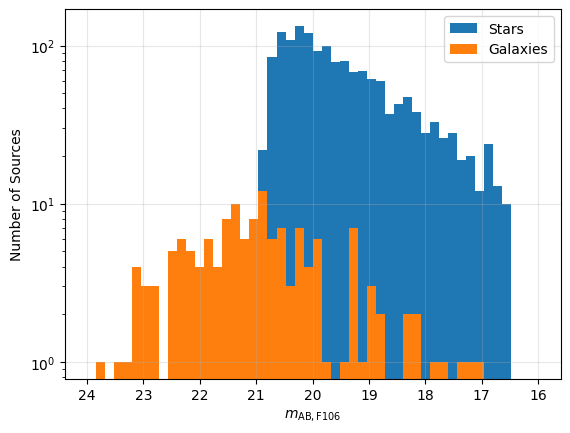

In [8]:
# Convert to AB magnitudes
stars['abmag'] = -2.5 * np.log10(stars['F106'])
galaxies['abmag'] = -2.5 * np.log10(galaxies['F106'])

# Create an histogram to identify the number
# of stars and galaxies with different AB magnitides.
fig, ax = plt.subplots()
ax.hist(stars['abmag'], bins=50, range=[16, 24], log=True, label='Stars')
ax.hist(galaxies['abmag'], bins=50, range=[16, 24], log=True, label='Galaxies')

ax.set_xlabel(r'$m_{\mathrm{AB, F106}}$')
ax.set_ylabel('Number of Sources')
ax.xaxis.set_inverted(True)
ax.legend()

ax.grid(alpha=0.3)

## Forced Aperture Photometry

Forced aperture photometry uses predefined source positions to place apertures and measure the flux within them. We use the source catalog information provided above for this. If source positions are unavailable, you will need to perform source detection first to determine their locations (see [Additional Resources](#Additional-Resources)).

### Correcting for Pixel Area

First, we need to correct our data for geometric distortion, which causes pixels to have different areas projected on the sky. The WFI distortion is described by a 2-D polynomial, and the area of each pixel is given by the determinant of the Jacobian matrix of this polynomial. A reference file, called the Pixel Area Map (PAM), provides the area per pixel of each WFI detector normalized to the nominal pixel area. The nominal pixel area is the pixel area at the tangent point about which the distortion polynomial is defined.

First, we can use the `crds` Python package to request the best pixel area map reference file that matches our observation. For this, CRDS needs to know the instrument name (WFI), detector name (WFI01), and the start time of the exposure. We can pull all of this information out of the metadata of the L2 file. Note that we need to specify the start time as a string, so we use `meta.exposure.start_time.isot` to convert the `astropy.time.Time` object in the metadata to an ISOT string (i.e., it has the format YYYY-MM-DDTHH:MM:SS.SSS). We set the argument `ignore_cache=True` below to force CRDS to update the files in our local cache. If this cell is re-run, we can set `ignore_cache=False` as we are confident we have pulled the latest information from the CRDS server. We also specify that the observatory is "roman" and that we want the "area" reference file type:

In [9]:
crds_result = crds.getreferences({'ROMAN.META.INSTRUMENT.DETECTOR': meta.instrument.detector,
                                  'ROMAN.META.INSTRUMENT.NAME': meta.instrument.name,
                                  'ROMAN.META.EXPOSURE.START_TIME': meta.exposure.start_time.isot}, 
                                 observatory='roman', reftypes=['area'], ignore_cache=True)

print(crds_result)

CRDS - INFO -  Fetching  /Users/rdiaz/crds_cache/mappings/roman/roman_wfi_skycells_0002.rmap      712 bytes  (1 / 38 files) (0 / 77.8 K bytes)
CRDS - INFO -  Fetching  /Users/rdiaz/crds_cache/mappings/roman/roman_wfi_saturation_0003.rmap    2.4 K bytes  (2 / 38 files) (712 / 77.8 K bytes)
CRDS - INFO -  Fetching  /Users/rdiaz/crds_cache/mappings/roman/roman_wfi_refpix_0003.rmap    2.3 K bytes  (3 / 38 files) (3.1 K / 77.8 K bytes)
CRDS - INFO -  Fetching  /Users/rdiaz/crds_cache/mappings/roman/roman_wfi_readnoise_0005.rmap    3.2 K bytes  (4 / 38 files) (5.5 K / 77.8 K bytes)
CRDS - INFO -  Fetching  /Users/rdiaz/crds_cache/mappings/roman/roman_wfi_photom_0004.rmap    2.3 K bytes  (5 / 38 files) (8.7 K / 77.8 K bytes)
CRDS - INFO -  Fetching  /Users/rdiaz/crds_cache/mappings/roman/roman_wfi_pars-tweakregstep_0001.rmap      568 bytes  (6 / 38 files) (11.0 K / 77.8 K bytes)
CRDS - INFO -  Fetching  /Users/rdiaz/crds_cache/mappings/roman/roman_wfi_pars-sourcedetectionstep_0001.rmap      6

{'area': '/Users/rdiaz/crds_cache/references/roman/wfi/roman_wfi_area_0009.asdf'}


We see that a dictionary is returned. The keys of the dictionary are the reference file types (e.g., "area"), and the values are the path to the correct file in your local CRDS cache. If the file is not in your cache, then the `crds.getreferences()` function will download the file to your local cache. At this time, CRDS does not support streaming reference files into memory from the CRDS server, but work is ongoing to adapt CRDS to cloud applications.

Next, let's take a look at the pixel area map that we now have:

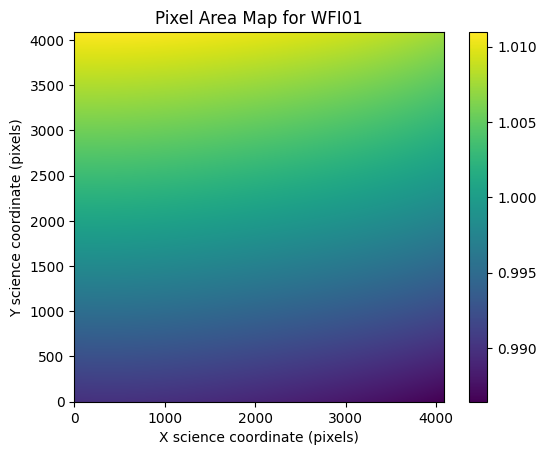

In [10]:
pam = rdm.open(crds_result['area'])

fig, ax = plt.subplots()
img = ax.imshow(pam.data, origin='lower')
ax.set_xlabel('X science coordinate (pixels)')
ax.set_ylabel('Y science coordinate (pixels)')
ax.set_title(f'Pixel Area Map for {pam.meta.instrument.detector}')
plt.colorbar(img);

Now let's multiply the science data and the uncertainty array by the PAM to adjust for the relative sizes of the pixels on the sky:

In [11]:
image *= pam.data
err *= pam.data

### Create Apertures

For simplicity, we will focus on the stars from this point on. From the catalogs, we now know the positions of every star. We can define a set aperture radii in units of pixels. In here we choose radii of 3 pixels:

In [12]:
rad = 3  # aperture radius in pixels

star_positions = [(x, y) for y, x in zip(stars['y'].data, stars['x'].data)]
star_apertures = CircularAperture(positions=star_positions, r=rad)

Also, let's create annulus apertures with $r_{in} = 20$ pixels and $r_{out} = 25$ pixels to measure local sky background values:

In [13]:
star_bkg_apertures = CircularAnnulus(positions=star_positions, r_in=20, r_out=25)

### Source Visualization

Let's plot our apertures on a subsection of the image to visually confirm that we have placed our apertures correctly. There may be a few small, fuzzy galaxies in the image that are not marked. This is fine since we are focusing on stars. Similarly, there may be several small features, detector imperfections, that are also not marked. Those will be masked in the data quality array.

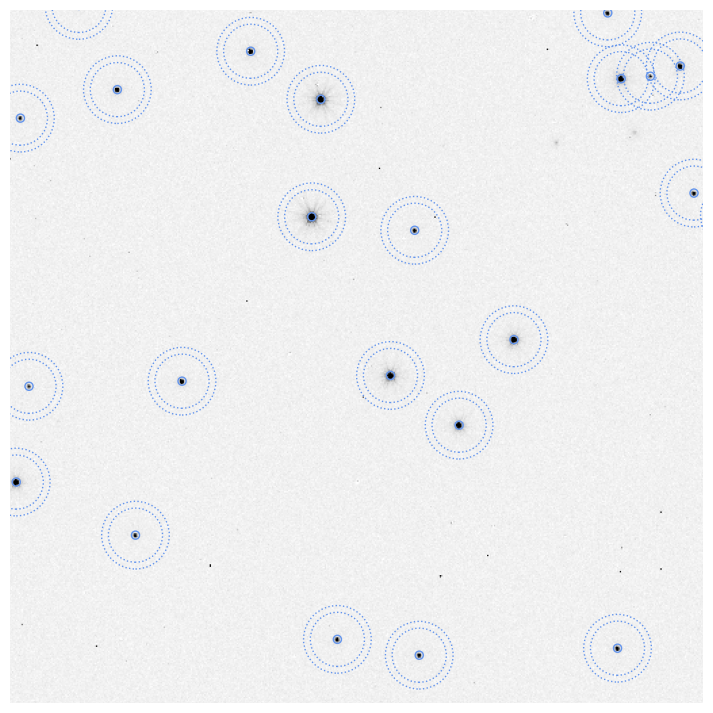

In [14]:
fig, ax = plt.subplots(figsize=(9, 9))

# show the simulated image
ax.imshow(image, origin='lower', vmin=0, vmax=12, cmap='gray_r')

# plot circles over bright galaxies and stars
star_apertures.plot(color='cornflowerblue')
star_bkg_apertures.plot(color='cornflowerblue', ls=':')

# zoom in on 1/16th of the image
ax.set_xlim(1024, 1536)
ax.set_ylim(1024, 1536)

plt.axis('off')
plt.show()

### Aperture Photometry with Photutils

We can now perform aperture photometry on the selected sources. First we measure the photometry in a circular aperture on each source:

In [15]:
columns = ('id', 'xcentroid', 'ycentroid', 'sum', 'sum_err')
star_phot = ApertureStats(image, star_apertures, error=err)
phot_tab = star_phot.to_table(columns)
phot_tab[:5]

id,xcentroid,ycentroid,sum,sum_err
int64,float64,float64,float64,float64
1,4047.4972909152084,640.2953153966586,2642.681566657021,5.488672086430786
2,3983.703847283155,878.6457742523635,107.33481975633413,1.3541310292849316
3,4059.7051143442886,1198.8515033373212,191.72264716086423,1.645956120742491
4,4066.514995718392,858.5475960110696,135.5474598448901,1.4682498573763318
5,3976.6420803446194,716.3110121010073,410.5286433968259,2.2933240160979875


And now let's do the same for the background annuli using the `ApertureStats` class. We will use the median of the pixels within the annulus as our estimate of the sky background **per pixel**. We will need to adjust this to the area of the star circular apertures (after accounting for the masked pixels).

In [16]:
columns = ('id', 'xcentroid', 'ycentroid', 'median', 'std')
sigclip = SigmaClip(sigma=3.0, maxiters=5)
star_bkg = ApertureStats(image, star_bkg_apertures, sigma_clip=sigclip, mask=dq)
star_bkg.to_table(columns)[:5]

id,xcentroid,ycentroid,median,std
int64,float64,float64,float64,float64
1,4047.778004866061,640.7406369462507,0.6385717689990997,0.1630904260689358
2,3983.420897141212,878.7913301338538,0.6235118508338928,0.16736493527375262
3,4059.49997712442,1198.9231899294557,0.6514447331428528,0.163246024548572
4,4063.877398350844,857.9297506879963,0.6254683434963226,0.1680694038503727
5,3976.522889173548,716.1357280656073,0.6373860239982605,0.17689512336474497


For our next steps, we will need the nominal pixel area in steradians (sr) and the zeropoint in megaJanskys per steradian (MJy/sr), both of which can be retrieved from the L2 metadata. Note that the pre-launch zeropoint is based on the unit response of the throughput curve of the integrated optical system (i.e., including all of the mirror reflectivities, optical element transmission, and detector quantum efficiency). The zeropoint also includes a factor of the median measured gain of the detector. The pre-launch zeropoint uncertainty is based solely on the standard deviation of the measured gain. After launch, these values will be updated using on-orbit observations of spectrophotometric standard stars and the photometric touchstone fields.

In [17]:
zpt = meta.photometry.conversion_megajanskys
pixel_area = meta.photometry.pixel_area

print(f'Zeropoint = {zpt} (MJy/sr) / (DN/s)')
print(f'Nominal pixel area = {pixel_area} sr')

Zeropoint = 0.7417487930165987 (MJy/sr) / (DN/s)
Nominal pixel area = 2.8083389953727505e-13 sr


Next, we subtract the sky background values from the source fluxes and propagate the uncertainty in the background into the total uncertainty:

In [18]:
flux_bkgsub = star_phot.sum - (star_bkg.median * star_apertures.area)
phot_tab['flux_jy'] = flux_bkgsub * zpt * 1e6 * pixel_area

We also need to correct our fluxes for the fraction of the starlight that falls outside of the aperture. The amount of light within the aperture as a function of the total light within a hypothetical infinite aperture is called the encircled energy and can be either measured from the image data using a series of apertures or can be determined from STPSF. In the future, a reference file in CRDS will also provide this information. For now, let's use STPSF:

In [19]:
wfi = stpsf.WFI()
wfi.filter = meta.instrument.optical_element
wfi.detector = f'SCA{meta.instrument.detector[-2:]}'
wfi.detector_position = (2043.5, 2043.5)
wfi_psf = wfi.calc_psf()
ee_func = stpsf.measure_ee(wfi_psf)

We can also plot the encircled energy as a function of aperture radius:

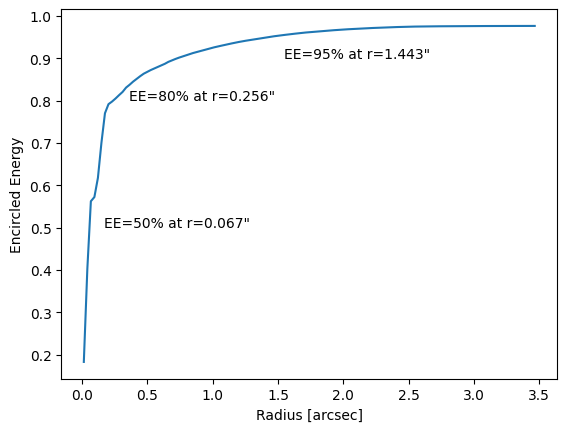

In [20]:
stpsf.display_ee(wfi_psf)

With these settings, our encircled energy measurement is an average for the whole detector, measured at the center of the detector, and for the default STPSF spectral energy distribution (SED), which is a 5700 K blackbody (similar to a G2V star). The variable `ee_func` above is a function that takes as its single argument the aperture radius in arcseconds and returns the percentage of the PSF contained within that aperture. The inverse of that encircled energy fraction is the correction factor that we must apply to our measurements. This is called the encircled energy correction or aperture correction. Let's calculate that now for a circular aperture with a 3-pixel radius and assuming a pixel scale of 0.11 arcseconds per pixel (i.e., radius = 0.33 arcseconds):

In [21]:
ee_correction = 1/ee_func(rad * 0.11)
print(f'Encircled energy correction = {ee_correction}')

Encircled energy correction = 1.2156172588041743


Now we can apply the aperture correction to our flux, and then convert the flux in Jy to maggies and AB magnitudes. For any source with a flux in maggies less than 0, we will assign a value of NaN for the AB magnitude. Recall that maggies are defined such that 1 maggie is equal to the reference flux for the AB magnitude system, which is 3,631 Jy. Thus, to convert our measurements from Jankys to maggies, we divide our fluxes by 3,631 Jy. We will also mask out any sources that have a flux of less than or equal to zero as those will not convert to magnitudes. Such sources exist where the background flux was statistically higher than the measured source flux.

In [22]:
phot_tab['flux_jy'] *= ee_correction
phot_tab['flux_maggies'] = phot_tab['flux_jy'] / 3631

# Mask out things with flux <= 0
mask = phot_tab['flux_maggies'] <= 0
phot_tab['flux_maggies'][mask] = np.nan
phot_tab['flux_jy'][mask] = np.nan

# Convert the flux to AB magnitudes
phot_tab['abmag'] = -2.5 * np.log10(phot_tab['flux_maggies'])

phot_tab[:5]

id,xcentroid,ycentroid,sum,sum_err,flux_jy,flux_maggies,abmag
int64,float64,float64,float64,float64,float64,float64,float64
1,4047.4972909152084,640.2953153966586,2642.681566657021,5.488672086430786,0.0006646158968711585,1.83039354687733e-07,16.84363881001557
2,3983.703847283155,878.6457742523635,107.33481975633413,1.3541310292849316,2.2715484521761775e-05,6.255985822572783e-09,20.509260610382583
3,4059.7051143442886,1198.8515033373212,191.72264716086423,1.645956120742491,4.388443617013781e-05,1.2086046865915123e-08,19.79428931506483
4,4066.514995718392,858.5475960110696,135.5474598448901,1.4682498573763318,2.984556737840137e-05,8.219655020215193e-09,20.212866023656233
5,3976.6420803446194,716.3110121010073,410.5286433968259,2.2933240160979875,9.939181430392684e-05,2.737312429191045e-08,18.906689076505806


Let's evaluate our results by plotting the difference between the simulated catalog and measured AB magnitudes. The blue points show the photometry of the stars, while the orange line shows the median offset between the input catalog and the measurements. The labeled uncertainty on the median is the standard deviation of the distribution. We also include a black line at an offset of 0 AB magnitudes as a reference.

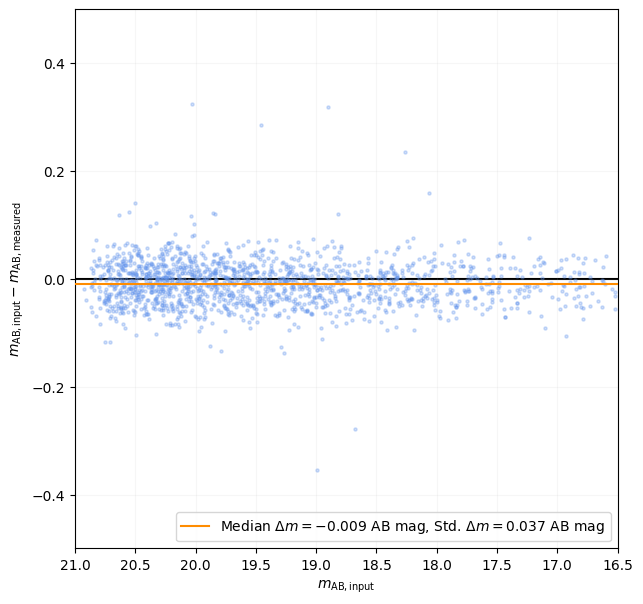

In [23]:
fig, ax = plt.subplots(figsize=(7, 7))

# Compute the offset between the input catalogs (stars) and measured (phot_tab) AB magnitudes and plot them
offset = stars['abmag'] - phot_tab['abmag']
ax.scatter(stars['abmag'], offset, s=5, color='cornflowerblue', alpha=0.3)

# Compute the median offset ignoring NaNs and plot the median and a reference line at 0
_, med, std = sigma_clipped_stats(offset[~np.isnan(offset)], sigma=5, maxiters=2)
ax.axhline(med, c='darkorange', label=fr'Median $\Delta m = {med:.3f}$ AB mag, Std. $\Delta m = {std:.3f}$ AB mag', zorder=1e4)
ax.axhline(0, color='black', zorder=-100)

# Restrict the axis limits for visibility. You may need to change these if you alter the input
# data for this tutorial.
ax.set_xlim(21, 16.5)
ax.set_ylim(-0.5, 0.5)

# Label the axes
ax.set_xlabel(r'$m_{\mathrm{AB, input}}$')
ax.set_ylabel(r'$m_{\mathrm{AB, input}} - m_{\mathrm{AB, measured}}$')
ax.legend(loc='lower right', fontsize=10)

# Overplot a reference grid
ax.grid(alpha=0.1)
plt.savefig('photometry.png')

Our measurements of stars in the image agree well with the input catalog fluxes at the level of approximately 0.9%. There could be several reasons why we see a small offset between the input and output magnitudes. First, we use a single value of the gain for our zeropoint, but we could do better and use a gain per pixel to convert the image from DN/s to photo-electrons per second and apply the zeropoint (with the gain removed). This would likely decrease the scatter in the plot. Secondly, we used a single aperture correction for the whole image based on the model of a star with an average SED and located at the center of the detector. A more detailed handling of the aperture correction may also decrease the scatter, and may also help bring the measurements into better alignment with the input catalog. Finally, a more careful treatment of other systematics (e.g., interpixel capacitance) may yield even better results.

A similar exercise in photometry can be repeated for the galaxies in the input catalog, but care should be taken when selecting apertures for galaxies as fixed aperture sizes will correspond to different physical sizes at the distances of galaxies. Other choices for galaxy apertures include, e.g., Kron apertures or isophotal apertures.

***

## Additional Resources
The [Photutils documentation](https://photutils.readthedocs.io/en/stable/) has additional tutorials for detecting and fitting sources in images:

- [Aperture photometry](https://photutils.readthedocs.io/en/stable/aperture.html)
- [Background estimation](https://photutils.readthedocs.io/en/stable/background.html)
- [Source detection](https://photutils.readthedocs.io/en/stable/detection.html)
- [PSF photometry](https://photutils.readthedocs.io/en/stable/psf.html)

## About This Notebook

**Author:** John F. Wu, Tyler Desjardins\
**Updated On:** 2025-09-30

<table width="100%" style="border:none; border-collapse:collapse;">
  <tr style="border:none;">
    <td style="border:none; width:180px; white-space:nowrap;">
       <a href="#top" style="text-decoration:none; color:#0066cc;">↑ Top of page</a> 
    </td>
    <td style="border:none; text-align:center;">
       <img src="../../roman_logo.png" width="50">
    </td>
    <td style="border:none; text-align:right;">
       <img src="../../stsci_logo2.png" width="90">
    </td>
  </tr>
</table>